# The Computational Image of the City: Landmarks

Four scores are here computed to extract computation landmarks: structural, visual, cultural, pragmatic.
The user has to provide at least an attribute shapefile containing the height attribute (the only mandatory field).
See below for further instructions on the data sources.

The user can also provide, seaprately, information about cultural/historical landmarks (e.g. position of listed important buildings); see *3 - Cultural component*

In [1]:
import pandas as pd, numpy as np, geopandas as gpd, osmnx as ox
from shapely.geometry import LineString
%matplotlib inline

import warnings
warnings.simplefilter(action="ignore")
pd.options.display.float_format = '{:20.2f}'.format
pd.options.mode.chained_assignment = None

import cityImage as ci

## Loading the layers

Proive the input path where the building layer of the city/area of interest is stored. This file shouldn't be exactly one's case-study area but a larger area (e.g. not Boston's city centre (case-study area), but the entire city of Boston).

Landmarks are extracted from buildings that are within the chosen case-study area (`buildings` geodataframe). Other buildings around the case study area have to be included in the analysis in order to correctly compute the landmark measures, namely, to avoid that buildings located along the boundaries of the case-study area benefit from the fact that in the `buildings` geodataframe outer buildings are not included.

In other words, `buildings` is a subset of `obstructions`.

One can set `option` to:
* `1` - Load one's `buildings` and `obstructions` gdfs from a local path. <span style="color:blue">Choose when: Files are ready and contains the `height`, and a `land_use` fields.</span>

* `2` - Get a large set of building from OSM (`obstructions`), extract the `buildings`, and attach information regarding `height` and `land_use` use from an existing file that it is in one's possession (if this file is for example issued by an official data source and therefore more complete than OSM). This step makes sense only if one's not comfortable with the shapes of the building footprints in their possession. Often these files contain footprints too precise and not fitting the purposes of this work. Instead, OSM provides already simplified footprints. <span style="color:blue"> Choose when: Having a shapefile with the `height` and `land_use` attributes but it is preferred to use the more simplified OSM geometries and attach the attributes to the OSM footprints.</span>

* `3` - Load a buildings dataframe that would correspond to `obstructions` and obtain the `buildings` geodataframe by using a certain distance or a case-study area polygon (see below for details). <span style="color:blue"> Choose when: Having a shapefile containing buildings in a large area, including and outside one's case study area; one is comfortable with the geometries and the `height` and `land_use` attributes are contained in such a file.</span>

Buildings smaller than 200 square meters are kept out of the analysis, as well as buildings whose height is lower than 1mt (when the `height` is filled).

###  Setting the coordinate systems of the case-study area

In [2]:
city_name = 'Boston'
epsg = 26986 
crs = 'EPSG:'+str(epsg)
input_path = 'Input/'+city_name+'/'
option = 3

In [3]:
# from local
case_study_area = gpd.read_file(input_path+city_name+'_city_center.shp').to_crs(epsg=epsg).iloc[0].geometry

In [ ]:
#specify the land use field's name in the file
height_field = 'height' 
base_field = 'base'
land_use_field = 'landUse'

### Option 1
Using already prepared `buildings` and `obstructions` datasets. One should be aware that `buildings` should be a perfect subset of `obstructions`. This means that all the buildings in `buildings` should be in `obstructions`, sharing the same attributes.

* The datasets should contain fields named `base` and `height`, representing the base height of the building (could be set to 0) and the height of the building.
* The `buildingID` should be already set correctly, that is, matching in the `obstructions`and `buildings` GeoDataFrames.

In [4]:
if option == 1:
    buildings = gpd.read_file(input_path+city_name+'_buildings.shp').to_crs(epsg=epsg)
    obstructions = gpd.read_file(input_path+city_name+'_obstructions.shp').to_crs(epsg=epsg)
    buildings.index, obstructions.index = buildings.buildingID, obstructions.buildingID
    buildings.index.name, obstructions.index.name = None, None
    obstructions['land_use_raw'] = obstructions[land_use_field]
    obsutrctions.drop(land_use_field, axis = 1, inplace = True)

### Option 2
Here one would download the obstructions from OpenStreetMap using a large metropolotin area of one's case-study area.
One has also the chance to attach attributes from a file in their possession and simplify the footprints.
The `buildings` GeoDataFrame is than obtained by using an OSM polygon representing the actual case-study area (and, in case, a buffer around it).

In [6]:
simplify = True
if option == 2:
    place = ''
    obstructions_tmp = ci.get_buildings_fromOSM(place, 'OSMplace', epsg = epsg, distance = None)
    obstructions_tmp = obstructions_tmp[obstructions_tmp.area > 1]

    ## simplify geometries?
    if simplify:
        obstructions_tmp = ci.simplify_footprints(obstructions_tmp, crs)
        obstructions_tmp['base'] = 0.0

    # attach attributes from..
    attribute_file = gpd.read_file(input_path+city_name+'_buildings_obstructions.shp').to_crs(epsg=epsg)

    # provide the name of the height, base_height, and land use attributes in your file
    obstructions = ci.attach_attributes(obstructions_na, attribute_file, height_field = height_field, 
                                        base_field = base_field, 
                                        lan_use_field = lan_use_field)
    
    # getting the polygon
    case_study_area = ox.geocode_to_gdf('Muenster Mitte').to_crs(epsg=epsg).iloc[0].geometry

    buildings = obstructions[obstructions.geometry.within(case_study_area)]
    buildings.index = buildings.buildingID
    buildings.index.name = None

### Option 3

If one doesn't have a precise case-study area polygon to pass: Use the parameter `distance_from_center` to indicate till how far away from the center of the case-study area one wants to include buildings. When the user doesn't provide the case-study area polygon nor the distance parameter, `buildings` and `obstructions` overlap; they have the same extent as the original input file.

`height_field` and `base_field` should indicate the maximum and the base elevations attributes of the buildings, in the original .shp file. When `base_field` is not provided, `base` is automatically set to 0. `height_field` is necessary to perform the landmark extraction. If such a feature is not at disposal, one should set `height_field` to `None`.

In [4]:
if option == 3:
    buildings, obstructions = ci.get_buildings_fromSHP(input_path+city_name+'_obstructions.shp', epsg, 
                                                       case_study_area = case_study_area, distance_from_center = 0, 
                                                       height_field = height_field, base_field = base_field, 
                                                       land_use_field = land_use_field)

### Optional readjustments

In [5]:
obstructions['land_use_raw'].unique()

array(['residential', None, 'school', 'Exempt', 'Industrial', 'house',
       'Commercial', 'Apartments 4-6 Units', 'retail',
       'Apartments 7 Units above', 'Residential Condo Unit',
       'Mixed Use Res/Comm', 'train_station', 'Residential Three Family',
       'Residential Two Family', 'Commercial Land', 'commercial',
       'police', 'theatre', 'Commercial Condo Unit', 'restaurant',
       'Condominium Master', 'Condominium Parking', 'Exempt 121A',
       'Residential Single Family', 'courthouse', 'industrial', 'library',
       'apartments', 'storage_tank', 'fast_food', 'factory', 'church',
       'bank', 'place_of_worship', 'garage', 'university', 'office',
       'bicycle_parking', 'dormitory', 'parking', 'bar', 'warehouse',
       'education', 'cinema', 'government', 'terrace', 'boathouse',
       'hotel', 'service', 'construction', 'arts_centre', 'college',
       'roof', 'fuel', 'shelter', 'civic', 'clinic', 'hospital',
       'emergency_service', 'garages', 'Residential 

In [8]:
land_use_to_disregard = ['stockroom, warehouse', 'garage', 'stable', 'workshop','converter', ' pumping station', 'barracks', 'barn'
       'greenhouse', 'shed','greenhouse (botany)', 'bunker, shelter','heating plant', 'parking, garage', 
               'electricity substation']
obstructions = obstructions[~((obstructions.land_use_raw.isin(land_use_to_disregard)) & (obstructions.area < 200))]

In [9]:
obstructions = obstructions[~((obstructions.land_use_raw.isnull()) & (obstructions.height.isnull()))]
height = obstructions[~obstructions.height.isnull()].height.quantile(0.25)
obstructions['height'] = obstructions['height'].where(obstructions['height'] > 0.0, height)
buildings = buildings[buildings.buildingID.isin(obstructions.buildingID)]

## Visualisation

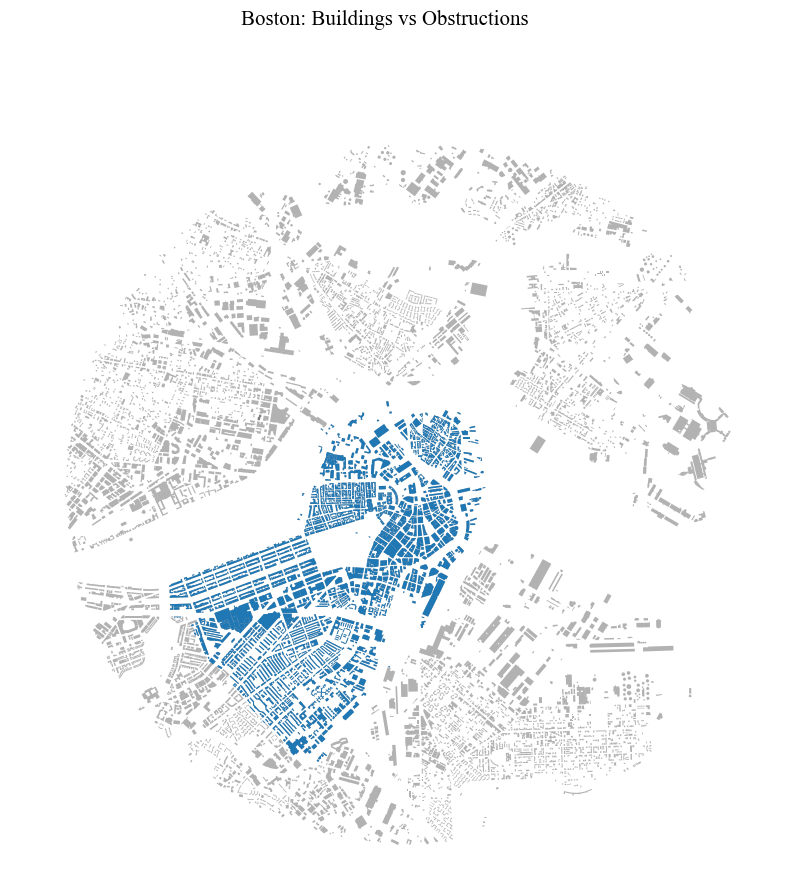

In [11]:
fig = ci.plot_gdf(buildings, scheme = None,  black_background = False, figsize = (10,10), 
                  title = city_name+': Buildings vs Obstructions', base_map_gdf = obstructions, base_map_color = 'black', 
                  base_map_alpha = 0.3)

## 1 - Structural component

It considers:
* The area of the building.
* Its distance from the road.
* The number of adjacent buildings, within the given `neighbours_radius`, around it.
* A measure of 2d advance visibility, expanded till a maximum distance from the center of the building on the basis of the `advance_vis_expansion_distance` parameter.

In [15]:
# reading the street network and passing it in the function to compute the structural score
edges = gpd.read_file('Output/'+city_name+'/'+city_name+'_edges.shp')

# The 'buffer' parameter indicates distance within the algorithms look for neighbouring buildings
buildings = ci.structural_score(buildings, obstructions, edges, advance_vis_expansion_distance = 300, 
                                neighbours_radius = 150)

## 2 - Visual component

### Sight Lines Construction
This is a computationally expensive step that may takes hours (in particular the intervisibility check that verifies whether the sigh lines are actually visible or not).
One way to reduce it is to cluster nodes and therefore generate a lower number of sight lines.
The function takes two parameters, besides the observer and the targets GeoDataFrames:
* `distance_along`: It regulates the interval along the exterior of each building for which a point is identified and used as a target point. If the exterior of the building is shorter than the parameter, at least one point is identified.
* `distance_min_observer_target`: The function only computes sight lines for nodes and buildings whose distance is higher than this parameter.


#### One can choose between two methods to compute the 3dvis score:

`combined` --> It computes a combined score that takes into account, per each building:
* The number of sight lines towards it.
* Their average length.
* The maximum lenght amongst them.

`longest` --> It just uses the longest sight line's length as a score



In [21]:
nodes = gpd.read_file('Output/'+city_name+'/'+city_name+'_nodes.shp')
sight_lines = ci.compute_3d_sight_lines(nodes, buildings, distance_along = 300,
                                                         distance_min_observer_target = 300)
buildings, sight_lines = ci.visibility_score(buildings, sight_lines, method = 'longest')
buildings.head()

,height,base,geometry,area,land_use_raw,buildingID,road,2dvis,neigh,fac,3dvis
0,23.53,1.72,"POLYGON ((237109.750 901488.558, 237000.835 90...",2466.09,Commercial Condo Unit,553,17.99,89352.63,20,1282.19,0.57
1,11.75,-1.29,"POLYGON ((237027.023 901476.820, 237001.853 90...",526.52,Commercial,554,17.84,38375.87,17,325.96,0.36
2,7.21,-0.38,"POLYGON ((237044.307 901416.818, 237004.172 90...",292.29,Commercial Land,555,17.79,41101.49,16,171.90,0.37
3,20.49,1.39,"POLYGON ((237142.368 901348.946, 237005.398 90...",2620.96,Residential Condo Unit,556,18.72,128536.86,15,1488.76,0.55
4,12.17,1.15,"POLYGON ((237199.594 901363.430, 237197.299 90...",793.82,Commercial,557,205.21,183974.08,7,382.03,0.54


In [23]:
saving_path = 'Output/'+city_name+'/'+city_name
sight_lines.to_file(saving_path+'_landmarks.shp', driver='ESRI Shapefile')

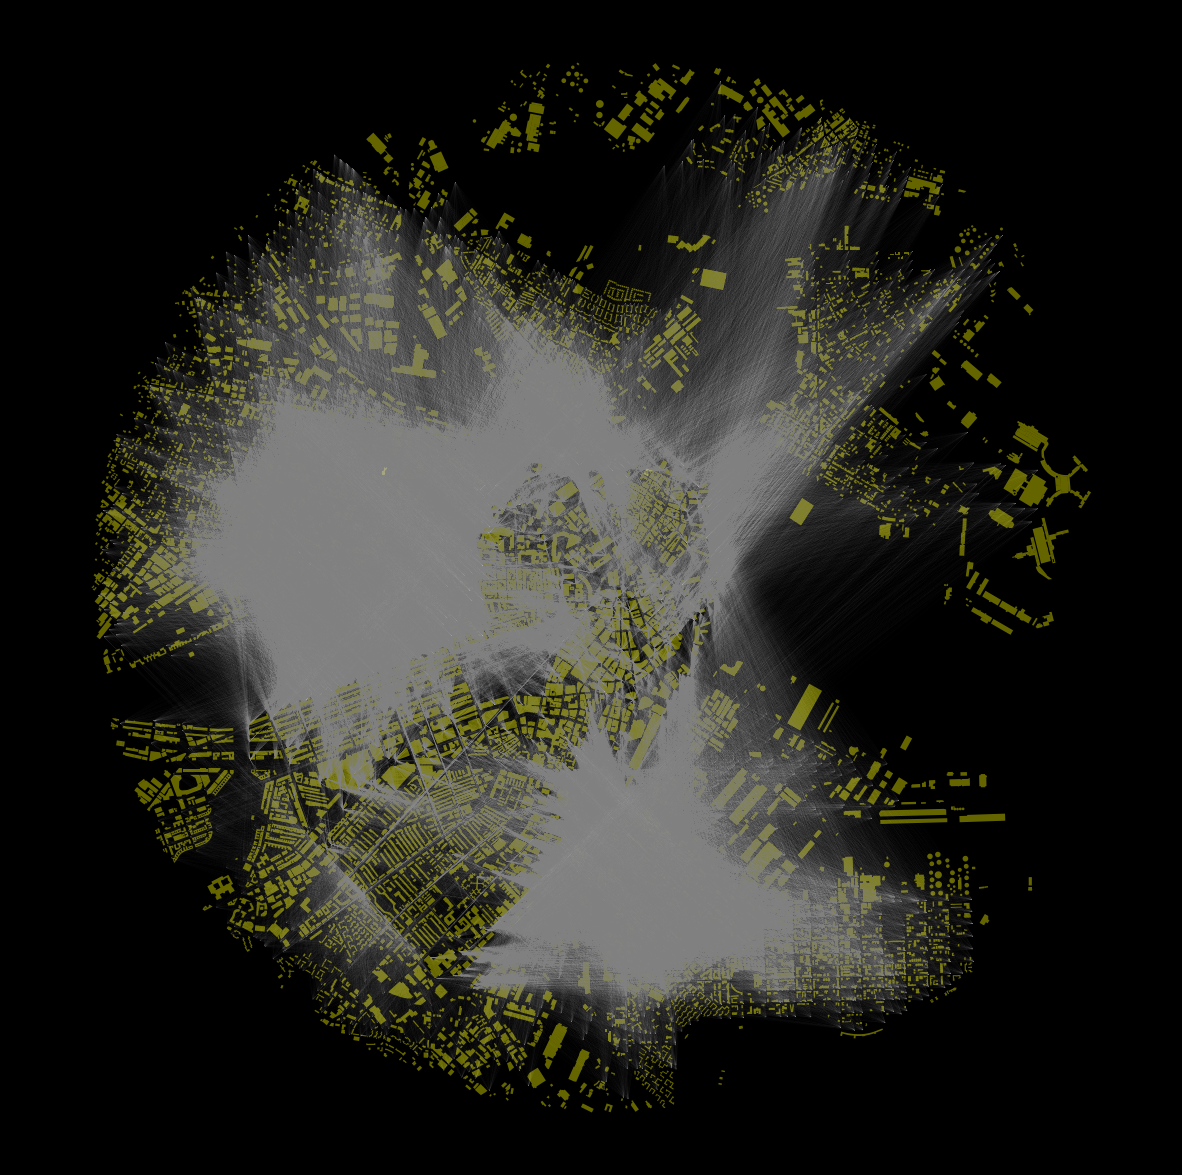

In [40]:
fig = ci.plot_gdf(sight_lines, alpha = 0.06, color = 'white', base_map_gdf = obstructions, base_map_color = 'yellow', 
            geometry_size = 0.09, base_map_alpha = 0.4)

## 3 - Cultural component

It measures the symbolic/cultural value of each building.
*This part is case-study specific, see other examples for generalizable methods*

In [43]:
cultural_elements = gpd.read_file(input_path+'otherSources/'+city_name+'_historic_landmarks.shp').to_crs(epsg=epsg)
buildings = ci.cultural_score(buildings, cultural_elements)

## 4 - Pragmatic component

Before computing the pragmatic score, the `land_use_raw` raw field is categorised into more granular categories. One can fill in the following categories to accomodate descriptors not accounted for. Run the 1st and the 2nd cells below so to check which descriptors in `land_use_raw` are not inclued at the moment in the macro categories.

In [48]:
# introducing classifications and possible entries

adult_entertainment = ['brothel','casino', 'swingerclub', 'stripclub', 'nightclub', 'gambling'] 
    
agriculture = ['shed', 'silo', 'greenhouse', 'stable', 'agricultural and forestry',  'greenhouse (botany)',  
               'building in the botanical garden']

attractions = ['attractions',   'attraction','aquarium', 'monument',  'gatehouse', 'terrace', 'tower', 'attraction and leisure',
               'information', 'viewpoint', 'tourist information center', 'recreation and amusement park',  'zoo',
               'exhibition hall, trade hall', 'boathouse', 'bath house, thermal baths', 'entertainment hall', 'sauna']

business_services = ['bank', 'service','offices', 'foundation', 'office', 'atm', 'bureau_de_change', 'post_office', 
              'post_office;atm', 'coworking_space', 'conference_centre',  'trade and services', 'trade and services building',
                      'customs office', 'insurance', 'tax_office', 'post', 'administrative building',  'facility building',
                      'residential building with trade and services', 'data_center', 'tax office']

commercial = [ 'commercial',  'retail', 'pharmacy', 'commercial;educa', 'shop', 'supermarket', 'books', 'commercial services',
              'commercial land', 'car_wash', 'internet_cafe', 'driving_school', 'marketplace', 'fuel', 'car_sharing', 
              'commercial and industry buidling',  'crematorium', 'commercial building', 'commercial and industry building',  
              'commercial building to traffic facilities (general)', 'funeral parlor', 'gas station', 'car wash',
              'pumping station','boat_rental', 'boat_sharing',  'bicycle_rental', 'car_rental', 'dive_centre'] 

culture = ['club_house','gallery', 'arts_centre','cultural facility', 'cultural_centre', 'theatre', 'cinema', 'studio',
            'exhibition_centre', 'music_school', 'theater','castle', 'museum', 'culture']
    
eating_drinking = ['bbq', 'restaurant', 'fast_food', 'cafe', 'bar',  'pub', 'accommodation, eating and drinking', 
                   'ice_cream', 'kitchen', 'food_court', 'cafe;restaurant', 'biergarten']

education_research = ['university', 'research', 'university building', 'education and research', 'research_institute',
                     'research_institu']

emergency_service = [ 'fire brigade','fire_station','police', 'emergency_service', 'resque_station', 'ranger_station',  
                     'security']

general_education = ['school', 'college', 'kindergarten', 'education', 'education and health', 'childcare',
             'language_school', 'children home',  'nursery',  'general education school']

hospitality = [ 'hotel',  'hostel', 'guest_house',  'building for accommodation',  'hotel, motel, pension',  'refuge']

industrial = ['industrial', 'factory', 'construction', 'manufacturing and production', 'gasometer', 'workshop', 
              'production building', 'manufacture']

medical_care = ['hospital', 'doctors', 'dentist','clinic','veterinary', 'medical care', 'nursing_home',  
                'sanatorium, nursing home', 'retirement home', 'healthcare', 'mortuary']

military_detainment = ['general aviation', 'barracks',  'military', 'penitentiary', 'prison']

other = ['toilets', 'picnic_site','hut', 'storage_tank', 'canopy','toilet',  'bunker, shelter', 'shelter','warehouse', 
         'converter',    'garage', 'garages','parking', 'block', 'roof', 'no', 'exempt','exempt 121a', 'bicycle_parking'] 

public = ['townhall', 'public_building',  'library','civic', 'courthouse', 'public', 'embassy',
          'public infrastructure', 'community_centre', 'court',  'district government', 'government',
          'residential building with public facilities']

religious = ['church', 'place_of_worship','convent', 'rectory', 'chapel', 'religious building', 'monastery', 'nuns home',
              'vocational school',  'cathedral', 'religious buildings']
residential = [ 'apartments', None, 'NaN', 'residential','flats', 'houses', 'building', 'residential land', 
               'residential building', 'student dorm', 'building usage mixed with living', 'house'
              'exempt', 'apartments 4-6 units', 'apartments 7 units above', 'residential condo unit', 'mixed use res/comm',
             'residential three family', 'residential two family','house', 'commercial condo unit', 'condominium master',
               'condominium parking', 'residential single family']

social = ['social_facility', 'community_centre', 'community buidling', 'dormitory', 'social_centre', 'social serives building', 
         'social services',  'community hall',  'commercial social facility',  'recreational']

sport = ['stadium', 'sport and entertainment', 'sports or exercise facility', 'gym', 'sports building', 'sports hall', 
         'horse riding school',  'swimming pool',  'sport hall', 'bowling hall',  'indoor swimming pool', 'grandstand']

transport = ['transport', 'road transport', 'station', 'subway_entrance', 'bus_station', 'shipping facility building', 
             'train_station',  'railway building',  'railway station and london underground station', 'railway station',
            'london underground station', 'light rapid transit station', 'light rapid transit station and railway station']

utilities = ['gas supply', 'electricity supply', 'electricity substation', 'waste treatment building',
            'water supply', 'waste water treatment plant', 'smokestack', 'supply systems', 'waste management', 'water works',
              'heating plant', 'boiler house',  'telecommunication']

In [49]:
obstructions['land_use_raw'] = obstructions['land_use_raw'].str.lower()
categories = [adult_entertainment, agriculture, attractions, business_services, commercial, culture, eating_drinking,
       education_research, emergency_service, general_education, hospitality, industrial, medical_care, military_detainment,
       other, public, religious, residential, social, sport, transport, utilities]
strings = ['adult_entertainment', 'agriculture', 'attractions', 'business_services', 'commercial', 'culture', 'eating_drinking',
       'education_research', 'emergency_service', 'general_education', 'hospitality', 'industrial', 'medical_care', 
           'military_detainment', 'other', 'public', 'religious', 'residential', 'social', 'sport', 'transport', 'utilities']

all_uses = [item for sublist in categories for item in sublist]
land_uses = list(obstructions.land_use_raw.unique())
to_categorise = [item for item in land_uses if item not in all_uses]

# shows existing raw categories to classify
to_categorise

[]

In [50]:
# and finally classify
obstructions = ci.classify_land_use(obstructions, 'land_use','land_use_raw', categories, strings)

### Pragmatic meaning computation

#### Computing the pragmatic score and assigning it to `buildings_gdf`.
The pragmatic component is computed on the `obstructions` GeoDataFrame as the measure is based on the adjacent buildings' land use categories. It is a measure of entropy, or information, for which an unusual land-use category within an area receives higher score. The `buffer` parameter indicates the extension of the area that is used to compute the score of a building, on the basis of its land-use's frequency.

In [53]:
obstructions = ci.pragmatic_score(obstructions, research_radius = 200)
buildings = pd.merge(buildings, obstructions[['prag', 'land_use', 'buildingID']], how = 'left', on = "buildingID")

### URBAN DMA Categorisation
The land use can also be cagtegorised into 3 categories see https://journals.sagepub.com/doi/full/10.1177/0042098018819727

In [54]:
visit = ['adult_entertainment', 'attractions', 'culture', 'eating_drinking', 'sport', 'religious', 'social', 'sport']
work = ['agriculture', 'business_services', 'commercial', 'education_research', 'emergency_service', 'general_education',
        'industrial','medical_care', 'military_detainment','public', 'transport','utilities']
live = ['hospitality', 'residential'] 

categories = [visit, work, live]
strings = ['visit', 'work', 'live']
buildings = ci.classify_land_use(buildings, 'DMA','land_use', categories, strings)

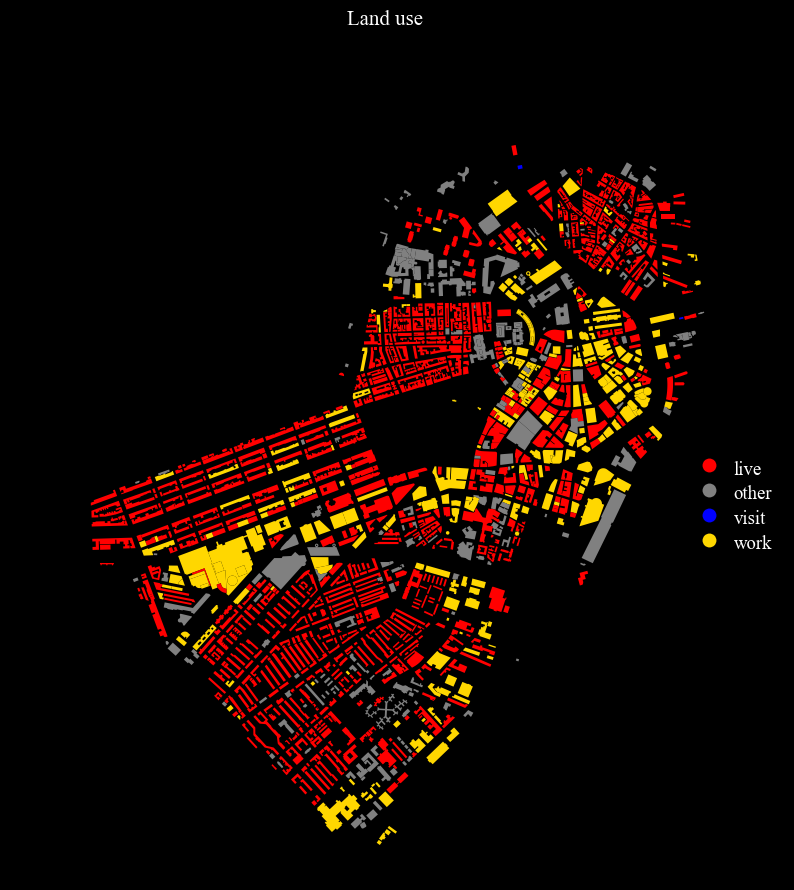

In [59]:
# visualising
from matplotlib.colors import LinearSegmentedColormap
colors = ['red', 'gray', 'blue', 'gold']
cmap = LinearSegmentedColormap.from_list('cmap', colors, N=len(colors))
fig = ci.plot_gdf(buildings, column = 'DMA', title = 'Land use', black_background = True, figsize = (10,10), cmap = cmap,
            legend = True)

# 5 - Final scores

### Defining Global indexes and components weights and assigning the score

In [61]:
global_indexes_weights = {'3dvis': 0.50, 'fac': 0.30, 'height': 0.20, 'area': 0.30, '2dvis':0.30, 'neigh': 0.20, 'road': 0.20}
global_components_weights = {'vScore': 0.50, 'sScore' : 0.30, 'cScore': 0.20, 'pScore': 0.10}   
buildings = ci.compute_global_scores(buildings, global_indexes_weights, global_components_weights)

### Define Local indexes and components weights

In [72]:
local_indexes_weights = {'3dvis': 0.50, 'fac': 0.30, 'height': 0.20, 'area': 0.40, '2dvis': 0.00, 'neigh': 0.30, 'road': 0.30}
local_components_weights = {'vScore': 0.25, 'sScore' : 0.35, 'cScore':0.10, 'pScore': 0.30}
rescaling_radius = 1000  # to define the local dimension, choose based on the extent of the case study area
buildings = ci.compute_local_scores(buildings, local_indexes_weights, local_components_weights, rescaling_radius = 
                                    rescaling_radius)

### Visualisation of the Components

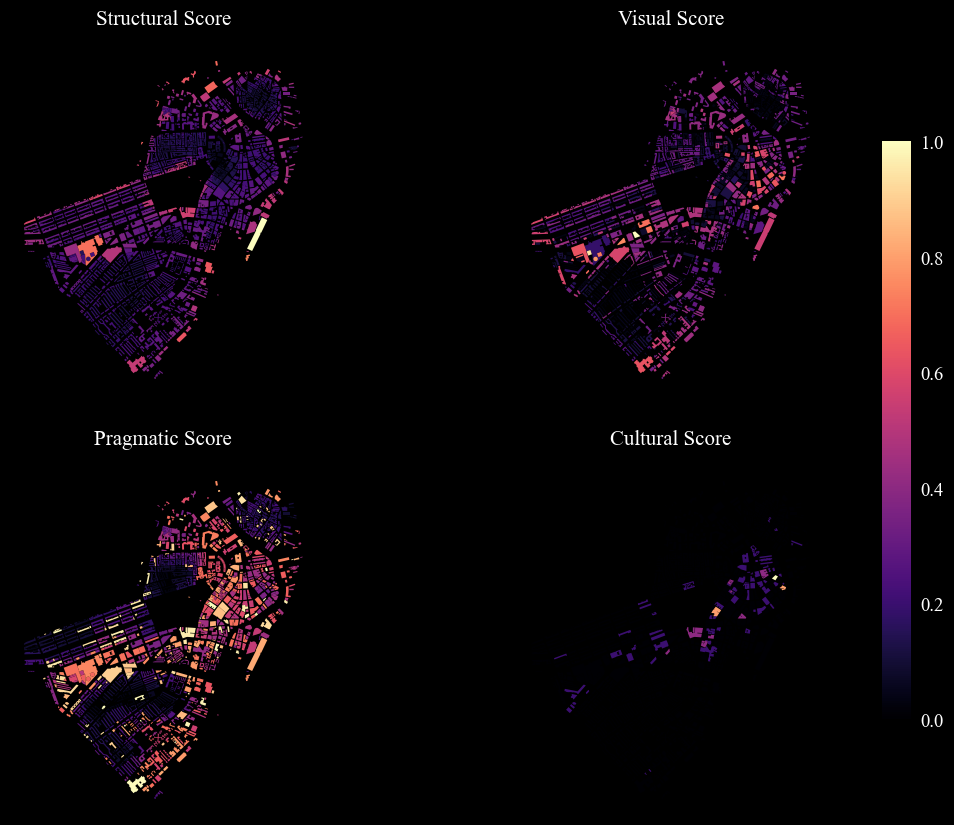

In [66]:
columns = ['sScore_sc', 'vScore_sc', 'pScore', 'cScore']
titles = ['Structural Score', 'Visual Score', 'Pragmatic Score', 'Cultural Score']
fig = ci.plot_grid_gdf_columns(gdf = buildings, columns = columns, titles = titles, black_background = True, figsize = (15,10),
                  scheme = 'fisher_jenks', cmap = 'magma', cbar = True, nrows = 2, ncols = 2)

### Visualisation of the Global and Local Landmark Scores

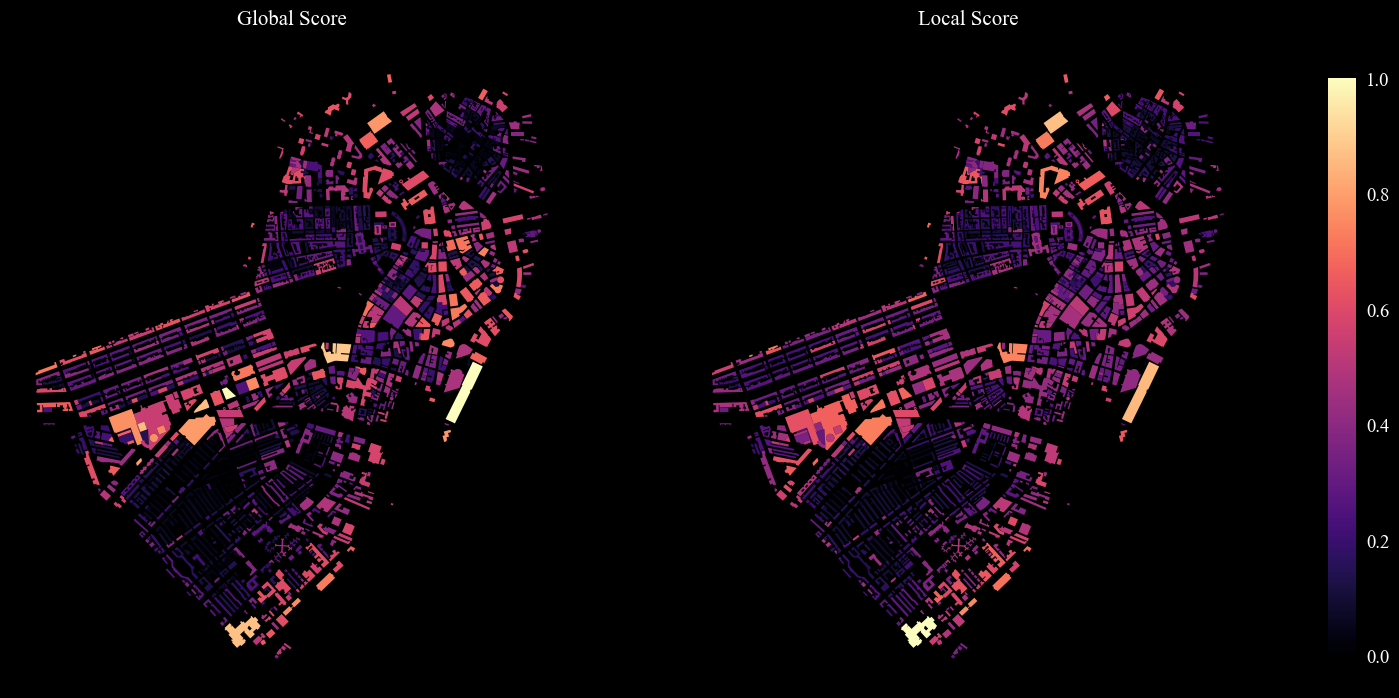

In [73]:
columns = ['gScore_sc', 'lScore_sc']
titles = ['Global Score', 'Local Score']
fig = ci.plot_grid_gdf_columns(gdf = buildings, columns = columns, titles = titles, black_background = True, figsize = (20,10),
                  scheme = 'fisher_jenks', cmap = 'magma', cbar = True, nrows = 1, ncols = 2)

In [74]:
buildings.to_file(saving_path+'_landmarks.shp', driver='ESRI Shapefile')